## Violations Search Tau

> Written by Jess Breda September 2023

For this notebook, I am working based on the to-dos from 2023-08-29 meeting and previous notebook `2023_08_violations_feature_analysis`/

The goals for this NB are

1. Update & test code to only apply exp filter to a session at a time

2. Update code to normalize all together before train test split. This might mean changing the order in generate_design_matrix. 
    * Or just a function that takes a list of dfs and finds the max value and normalize them by it?
    * Or just pass in the generated design matrix into train test split

3. Iterate over a finer grid of taus and sigmas

sigmas = 0.01, 0.1, 0.2, 0.5, 1, 1.5, 2, 2.5, 3, 5

taus = 1, 2, 3, 5, 10, 12, 15, 17, 20, 25, 30

In [51]:
import pathlib
import platform
import sys
[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_context("talk")

from sklearn.model_selection import KFold, train_test_split

from generate_design_matrix import *
from get_rat_data import *
from multiclass_logistic_regression import *

MODE = "local"

# settings
%load_ext autoreload
%autoreload 2

### Apply exp filter on session by session basis

In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


class ExpFilter:
    def __init__(self, tau, column="violation", len_factor=5, verbose=True):
        self.tau = tau
        self.column = column
        self.len_factor = len_factor
        self.verbose = verbose

    def create_kernel(self):
        return np.array(
            [np.exp(-i / self.tau) for i in range(self.len_factor * self.tau)]
        )

    def plot_kernel(self):
        kernel = self.create_kernel()
        fig, ax = plt.subplots(figsize=(6, 4))
        plt.plot(kernel)
        plt.title(f"Exponential filter kernel | Tau: {self.tau}")
        plt.show()

    def apply_filter_to_session(self, session_df):
        kernel = self.create_kernel()

        # Convolve the kernel with selected column
        convolution_result = np.convolve(session_df[self.column], kernel, mode="full")[
            : len(session_df)
        ]

        session_df[f"{self.column}_exp_{self.tau}"] = convolution_result

        return session_df

    def apply_filter_to_dataframe(self, source_df, output_df=None):
        if self.tau is None:
            return

        if output_df is None:
            output_df = source_df

        for session_id, session_data in source_df.groupby("session"):
            filtered_session = self.apply_filter_to_session(session_data.copy())
            output_df.loc[
                output_df["session"] == session_id, f"{self.column}_exp_{self.tau}"
            ] = filtered_session[f"{self.column}_exp_{self.tau}"]

            if self.verbose:
                print(
                    f"Exp filter added for session {session_id} | Column: {self.column}, Tau: {self.tau}"
                )

        # scale column by max to bound between 0 and 1
        output_df[f"{self.column}_exp_{self.tau}"] /= output_df[
            f"{self.column}_exp_{self.tau}"
        ].max()


# Example usage
df = pd.DataFrame(
    {
        "session": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
        "violation": np.random.randint(0, 2, 22),
    }
)

filter_obj = ExpFilter(tau=3, column="violation")
filter_obj.apply_filter_to_dataframe(df)

Exp filter added for session 1 | Column: violation, Tau: 3
Exp filter added for session 2 | Column: violation, Tau: 3
Exp filter added for session 3 | Column: violation, Tau: 3


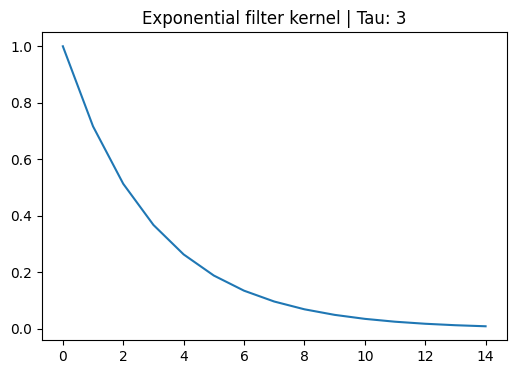

In [47]:
filter_obj.plot_kernel()

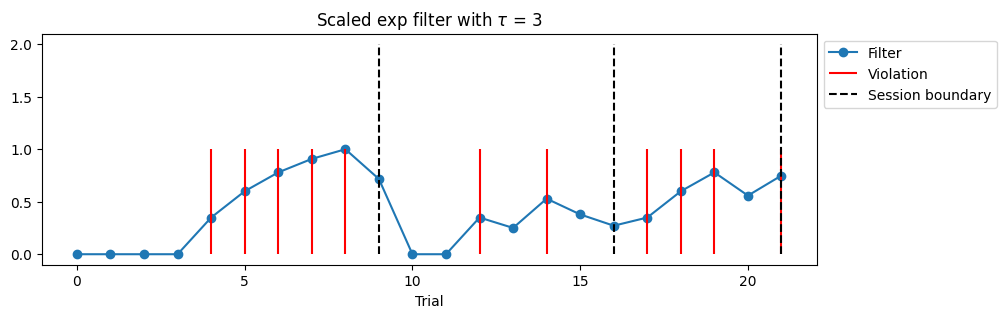

In [48]:
plot_kernel_validation(df, "violation_exp_3")

In [110]:
ANIMAL_ID = "W065"
df = get_rat_viol_data(animal_ids=ANIMAL_ID)

returning data for W065


In [115]:
class DesignMatrixGenerator:
    def __init__(self, tau=None, verbose=True):
        self.tau = tau
        self.verbose = verbose

        if self.tau is not None:
            self.exp_filter = ExpFilter(tau=self.tau, verbose=self.verbose)

    @staticmethod
    def normalize_column(col):
        return (col - col.mean()) / col.std()

    def generate_design_matrix(self, df, return_labels=True):
        """
        Function to generate "base" design matrix given a dataframe
        with violations tracked. In this case "base" means using the
        same regressors as Nick Roy did in Psytrack, but adjusted to
        take into account 3 choice options (L,R, Violation).

        N = number of trials
        D = number of features
        C = number of classes, in this case 3 (L, R, Violation)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `s_a` `s_b` `session`, `violation`
            `correct_side` and `choice`, likely generated by
            get_rat_viol_data()
        return_label : bool (default: True)
            whether to return one-hot encoded choice labels

        returns
        -------
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with regressors for s_a, s_b,
            prev sound avg, correct side and choice info,
            normalized to standard normal with bias column added
        Y : np.ndarray, shape (N, C), where C = 3 if return_labels=True
            one-hot encoded choice labels for each trial as left,
            right or violation
        """
        # Initialize
        X = pd.DataFrame()
        stim_cols = ["s_a", "s_b"]

        # Masks- if first trial in a session and/or previous trial
        # was a violation, "prev" variables get set to 0
        session_boundaries_mask = df["session"].diff() == 0
        prev_violation_mask = (
            df["violation"].shift() * session_boundaries_mask
        ).fillna(0) == 0

        # Stimuli (s_a, s_b) get normalized
        for col in stim_cols:
            X[stim_cols] = self.normalize_column(df[stim_cols])

        # Average previous stimulus (s_a, s_b) loudness
        X["prev_sound_avg"] = df[stim_cols].shift().mean(axis=1)
        X["prev_sound_avg"] = self.normalize_column(X["prev_sound_avg"])
        X["prev_sound_avg"] *= session_boundaries_mask * prev_violation_mask

        # Prev correct side (L, R) (0, 1) -> (-1, 1),
        X["prev_correct"] = (
            df.correct_side.replace({0: -1}).astype(int).shift()
            * session_boundaries_mask
            * prev_violation_mask
        )

        # prev choice regressors (L, R, V) (0, 1, Nan) -> (-1, 1, 0),
        X["prev_choice"] = (
            df.choice.replace({0: -1}).fillna(0).astype(int).shift()
            * session_boundaries_mask
        )

        X.fillna(0, inplace=True)  # remove nan from shift()
        X.insert(0, "bias", 1)  # add bias column

        # Apply exponential filter if tau is not None
        if self.tau is not None:
            X["session"] = df.session # add session column for alignmnet
            self.exp_filter.apply_filter_to_dataframe(df, output_df=X)
            X.drop(columns=["session"], inplace=True)

        if return_labels:
            Y = self.one_hot_encode_labels(df)
            return X, Y
        else:
            return X

    def one_hot_encode_labels(df):
        """
        Function to one-hot encode choice labels for each trial as
        left, right or violation (C = 3)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `choice` likely generated by
            get_rat_viol_data()

        returns
        -------
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        """

        Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)
        return Y

In [146]:
dmg = DesignMatrixGenerator(tau=5, verbose=False)
XX = dmg.generate_design_matrix(df, return_labels=False)

everything is looking good and i've validated the kernel with with the sessiona nd the design matrix new/old. Next up, put these in a single py file, get rid of old functions and start to fit.